In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import Input

# Set visualization styles
sns.set_style('darkgrid')
plt.style.use("fivethirtyeight")

# Define the companies and their tickers
companies = {
    "GOOGLE": "GOOG",
    "AMAZON": "AMZN",
    "APPLE": "AAPL",
    "META": "META",
    "NETFLIX": "NFLX"
}

In [2]:
# Fetch real-time stock data
def fetch_real_time_data(tickers, start_date='2020-01-01'):
    dataframes = {}
    for company, ticker in tickers.items():
        print(f"Fetching data for {company} ({ticker})...")
        df = yf.download(ticker, start=start_date)
        df.reset_index(inplace=True)
        df['Ticker'] = ticker
        dataframes[ticker] = df
    combined_df = pd.concat(dataframes.values(), ignore_index=True)
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])
    return combined_df

# Fetch real-time data for MAANG companies
combined_df = fetch_real_time_data(companies)

Fetching data for GOOGLE (GOOG)...


[*********************100%***********************]  1 of 1 completed


Fetching data for AMAZON (AMZN)...


[*********************100%***********************]  1 of 1 completed


Fetching data for APPLE (AAPL)...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching data for META (META)...
Fetching data for NETFLIX (NFLX)...


[*********************100%***********************]  1 of 1 completed


In [3]:
# Calculate moving averages
for ticker in companies.values():
    combined_df.loc[combined_df['Ticker'] == ticker, 'MA20'] = combined_df.loc[
        combined_df['Ticker'] == ticker, 'Close'].rolling(window=20, min_periods=1).mean()
    combined_df.loc[combined_df['Ticker'] == ticker, 'MA40'] = combined_df.loc[
        combined_df['Ticker'] == ticker, 'Close'].rolling(window=40, min_periods=1).mean()

In [4]:
# Flatten MultiIndex columns into single-level columns
combined_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in combined_df.columns]

# Print flattened column names to verify
print("Flattened column names:")
print(combined_df.columns)


Flattened column names:
Index(['Date_', 'Adj Close_GOOG', 'Close_GOOG', 'High_GOOG', 'Low_GOOG',
       'Open_GOOG', 'Volume_GOOG', 'Ticker_', 'Adj Close_AMZN', 'Close_AMZN',
       'High_AMZN', 'Low_AMZN', 'Open_AMZN', 'Volume_AMZN', 'Adj Close_AAPL',
       'Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL',
       'Adj Close_META', 'Close_META', 'High_META', 'Low_META', 'Open_META',
       'Volume_META', 'Adj Close_NFLX', 'Close_NFLX', 'High_NFLX', 'Low_NFLX',
       'Open_NFLX', 'Volume_NFLX', 'MA20_', 'MA40_'],
      dtype='object')


In [5]:
def create_candlestick(df, ticker):
    # Find the 'Date' column dynamically
    date_col = [col for col in df.columns if 'Date' in col or 'date' in col]
    if not date_col:
        print("Date column not found. Skipping...")
        return

    date_col = date_col[0]  # Use the identified date column

    # Dynamically identify the correct columns for the specific ticker
    open_col = f"Open_{ticker}"
    high_col = f"High_{ticker}"
    low_col = f"Low_{ticker}"
    close_col = f"Close_{ticker}"

    # Check if all required columns exist
    required_cols = [open_col, high_col, low_col, close_col]
    if not all(col in df.columns for col in required_cols):
        print(f"Required columns for {ticker} not found. Skipping...")
        return

    # Create a filtered DataFrame with the required columns
    df_filtered = df[[date_col, open_col, high_col, low_col, close_col]].copy()
    df_filtered.columns = ['Date', 'Open', 'High', 'Low', 'Close']  # Rename columns to standard names

    # Drop rows with missing values
    df_filtered = df_filtered.dropna()

    # Check if there is valid data to plot
    if df_filtered.empty:
        print(f"No valid data to plot for {ticker}.")
        return

    # Plot candlestick chart
    figure = go.Figure(data=[go.Candlestick(
        x=df_filtered["Date"],
        open=df_filtered["Open"],
        high=df_filtered["High"],
        low=df_filtered["Low"],
        close=df_filtered["Close"],
        increasing_line_color='cyan',
        decreasing_line_color='red'
    )])
    figure.update_layout(
        title=f"{ticker} Stock Prices",
        xaxis_rangeslider_visible=False
    )
    figure.show()

# Call the function for all tickers
for ticker in companies.values():
    print(f"Processing data for {ticker}...")
    create_candlestick(combined_df, ticker)


Processing data for GOOG...


Processing data for AMZN...


Processing data for AAPL...


Processing data for META...


Processing data for NFLX...


In [7]:
# Calculate moving averages dynamically for each ticker
for ticker in companies.values():
    print(f"Calculating moving averages for {ticker}...")

    close_col = f"Close_{ticker}"  # Identify the correct Close column
    ma20_col = f"MA20_{ticker}"    # Moving Average 20 column
    ma40_col = f"MA40_{ticker}"    # Moving Average 40 column

    # Check if the Close column exists
    if close_col not in combined_df.columns:
        print(f"Close column {close_col} not found. Skipping {ticker}...")
        continue

    # Calculate the moving averages and add to DataFrame
    combined_df[ma20_col] = combined_df[close_col].rolling(window=20, min_periods=20).mean()
    combined_df[ma40_col] = combined_df[close_col].rolling(window=40, min_periods=40).mean()

    # Plot moving averages for each ticker
for ticker in companies.values():
    print(f"Processing moving averages for {ticker}...")

    # Dynamically identify the columns for the current ticker
    close_col = f"Close_{ticker}"
    ma20_col = f"MA20_{ticker}"
    ma40_col = f"MA40_{ticker}"

    # Check if the required columns exist
    required_cols = [date_col, close_col, ma20_col, ma40_col]
    missing_cols = [col for col in required_cols if col not in combined_df.columns]
    if missing_cols:
        print(f"Missing columns {missing_cols} for {ticker}. Skipping...")
        continue

    # Filter and rename columns for plotting
    data = combined_df[[date_col, close_col, ma20_col, ma40_col]].copy()
    data.columns = ['Date', 'Close', 'MA20', 'MA40']  # Rename for uniformity

    # Plot moving averages
    fig = px.line(
        data,
        x='Date',
        y=['Close', 'MA20', 'MA40'],
        title=f"{ticker} Stock Price with Moving Averages",
        labels={'value': 'Price', 'variable': 'Metric'}
    )
    fig.show()


Calculating moving averages for GOOG...
Calculating moving averages for AMZN...
Calculating moving averages for AAPL...
Calculating moving averages for META...
Calculating moving averages for NFLX...
Processing moving averages for GOOG...


NameError: name 'date_col' is not defined

In [8]:
# Step 1: Inspect Columns
print("Available columns in combined_df:")
print(combined_df.columns)

# Step 2: Dynamically Find the Ticker Column
ticker_col = [col for col in combined_df.columns if 'Ticker' in col or 'ticker' in col]
if not ticker_col:
    raise KeyError("No column matching 'Ticker' found in combined_df.")
ticker_col = ticker_col[0]  # Use the identified column
print(f"Ticker column found: {ticker_col}")

# Step 3: Dynamically Find the Close Column for NFLX
close_col = [col for col in combined_df.columns if 'Close' in col and 'NFLX' in col]
if not close_col:
    raise KeyError("No column matching 'Close_NFLX' found in combined_df.")
close_col = close_col[0]
print(f"Close column for NFLX found: {close_col}")

# Step 4: Use the Correct 'Date_' Column
date_col = [col for col in combined_df.columns if 'Date' in col]
if not date_col:
    raise KeyError("No column matching 'Date' found in combined_df.")
date_col = date_col[0]
print(f"Date column found: {date_col}")

# Step 5: Filter the Data for Netflix
try:
    nflx_df = combined_df[combined_df[ticker_col] == 'NFLX'][[date_col, close_col]].copy()
    nflx_df.columns = ['Date', 'Close']  # Rename columns for simplicity
    print("Filtered Netflix data:")
    print(nflx_df.head())
except KeyError as e:
    print(f"Error filtering Netflix data: {e}")
    raise

# Step 6: Normalize the Data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Ensure no NaN values exist before scaling
nflx_df = nflx_df.dropna()
scaled_data = scaler.fit_transform(nflx_df['Close'].values.reshape(-1, 1))
print("Scaled data shape:", scaled_data.shape)


Available columns in combined_df:
Index(['Date_', 'Adj Close_GOOG', 'Close_GOOG', 'High_GOOG', 'Low_GOOG',
       'Open_GOOG', 'Volume_GOOG', 'Ticker_', 'Adj Close_AMZN', 'Close_AMZN',
       'High_AMZN', 'Low_AMZN', 'Open_AMZN', 'Volume_AMZN', 'Adj Close_AAPL',
       'Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL',
       'Adj Close_META', 'Close_META', 'High_META', 'Low_META', 'Open_META',
       'Volume_META', 'Adj Close_NFLX', 'Close_NFLX', 'High_NFLX', 'Low_NFLX',
       'Open_NFLX', 'Volume_NFLX', 'MA20_', 'MA40_', 'MA20_GOOG', 'MA40_GOOG',
       'MA20_AMZN', 'MA40_AMZN', 'MA20_AAPL', 'MA40_AAPL', 'MA20_META',
       'MA40_META', 'MA20_NFLX', 'MA40_NFLX'],
      dtype='object')
Ticker column found: Ticker_
Close column for NFLX found: Adj Close_NFLX
Date column found: Date_
Filtered Netflix data:
           Date       Close
4992 2020-01-02  329.809998
4993 2020-01-03  325.899994
4994 2020-01-06  335.829987
4995 2020-01-07  330.750000
4996 2020-01-08  339.26001

In [9]:
# Prepare training and testing data
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 100:]

# Create sequences for LSTM
def create_sequences(data, sequence_length=100):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

x_train, y_train = create_sequences(train_data)
x_test, y_test = create_sequences(test_data)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [11]:
# Build LSTM model
model = Sequential([
    Input(shape=(x_train.shape[1], 1)),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.0788
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0045
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0028
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0021
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - loss: 0.0021
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 0.0023
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0021
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0019
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0019
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0022


In [12]:
# Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


In [13]:
# Example: Assuming `model` is your trained LSTM model
# Use the last `window_size` data points for prediction

import numpy as np
from datetime import datetime

# Assume `scaler` is your MinMaxScaler
window_size = 60
latest_data = scaled_data[-window_size:]  # Fetch last 'window_size' normalized values
latest_data = np.reshape(latest_data, (1, window_size, 1))  # Reshape for LSTM input

# Predict the next price
predicted_value = model.predict(latest_data)  # Predict normalized value
next_price = scaler.inverse_transform(predicted_value)[0][0]  # Reverse scale to original value

# Print the result with timestamp
print(f"[{datetime.now()}] Predicted Next Price: {next_price:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
[2024-12-17 05:20:23.839968] Predicted Next Price: 901.93


In [14]:
print(f"Fetched data at: {datetime.now()}")


Fetched data at: 2024-12-17 05:20:26.930669


In [15]:
# Evaluate RMSE
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 29.312280227976597


In [16]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Mean Absolute Error (MAE): 22.78


In [17]:
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Percentage Error (MAPE): 3.39%


In [18]:
from datetime import datetime
import time
import yfinance as yf

ticker = "NFLX"  # Example ticker: Netflix

# Real-time fetching loop
for i in range(5):  # Fetch data 5 times
    try:
        # Fetch the latest 1-day hourly data
        new_data = yf.download(ticker, period='1d', interval='1h')

        # Check if data is not empty
        if not new_data.empty:
            latest_price = new_data['Close'].iloc[-1]  # Force to scalar value
            latest_price = float(latest_price)  # Ensure it's a float
            print(f"[{datetime.now()}] Fetched Price: {latest_price:.2f}")
        else:
            print(f"[{datetime.now()}] No new data fetched for {ticker}.")

    except Exception as e:
        print(f"Error fetching data: {e}")

    time.sleep(60)  # Fetch data every 1 minute


[*********************100%***********************]  1 of 1 completed
<ipython-input-18-a77678278cf1>:16: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



[2024-12-17 05:20:38.090812] Fetched Price: 921.12


[*********************100%***********************]  1 of 1 completed
<ipython-input-18-a77678278cf1>:16: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



[2024-12-17 05:21:38.232036] Fetched Price: 921.12


[*********************100%***********************]  1 of 1 completed
<ipython-input-18-a77678278cf1>:16: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



[2024-12-17 05:22:38.374863] Fetched Price: 921.12


[*********************100%***********************]  1 of 1 completed
<ipython-input-18-a77678278cf1>:16: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



[2024-12-17 05:23:38.491354] Fetched Price: 921.12


[*********************100%***********************]  1 of 1 completed
<ipython-input-18-a77678278cf1>:16: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



[2024-12-17 05:24:38.639697] Fetched Price: 921.12


In [125]:
def plot_predictions_for_ticker(df, ticker, model, scaler, sequence_length=100):
    # Dynamically find the 'Ticker' column
    ticker_col = [col for col in df.columns if 'Ticker' in col or 'ticker' in col]
    if not ticker_col:
        print("No Ticker column found. Skipping...")
        return
    ticker_col = ticker_col[0]

    # Dynamically find the 'Date' and 'Close' columns for the specific ticker
    date_col = [col for col in df.columns if 'Date' in col or 'date' in col][0]
    close_col = [col for col in df.columns if f'Close_{ticker}' in col or f'close_{ticker}' in col]
    if not close_col:
        print(f"No 'Close' column found for {ticker}. Skipping...")
        return
    close_col = close_col[0]  # Use the first match

    # Filter data for the selected ticker
    ticker_df = df[df[ticker_col] == ticker][[date_col, close_col]].copy()
    ticker_df.columns = ['Date', 'Close']
    ticker_df = ticker_df.dropna()

    # Normalize the Close prices
    scaled_data = scaler.fit_transform(ticker_df['Close'].values.reshape(-1, 1))

    # Prepare training and testing data
    train_size = int(len(scaled_data) * 0.8)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size - sequence_length:]

    # Create sequences for LSTM
    def create_sequences(data, seq_length):
        x, y = [], []
        for i in range(seq_length, len(data)):
            x.append(data[i-seq_length:i, 0])
            y.append(data[i, 0])
        return np.array(x), np.array(y)

    x_test, y_test = create_sequences(test_data, sequence_length)
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    # Make predictions
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Plot Actual vs Predicted
    plt.figure(figsize=(10, 6))
    plt.plot(ticker_df['Date'][-len(y_test):], y_test, color='black', label="Actual")
    plt.plot(ticker_df['Date'][-len(predictions):], predictions, color='blue', label="Predicted")
    plt.title(f"{ticker} Stock Price Prediction")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()


Processing predictions for GOOG...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


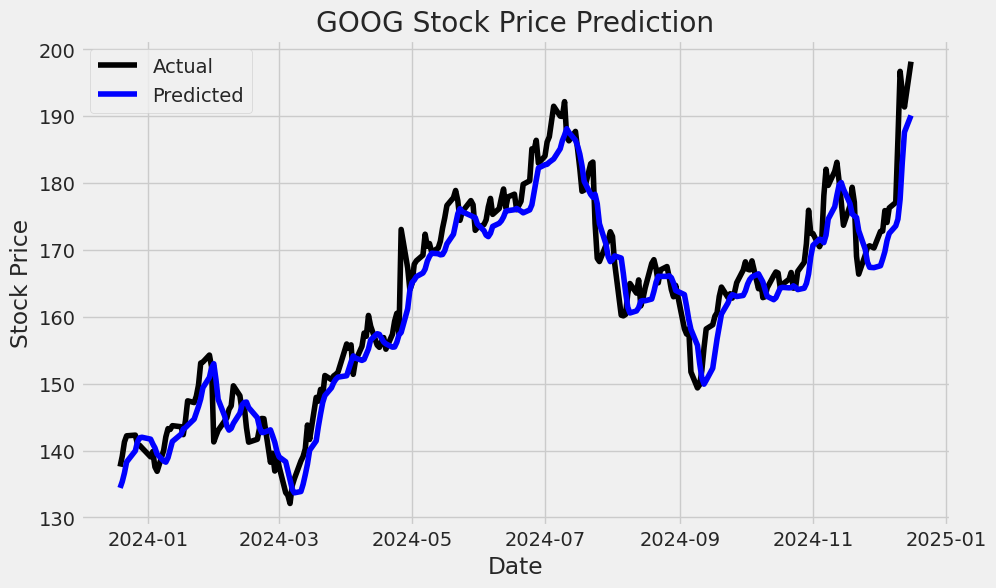

Processing predictions for AMZN...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


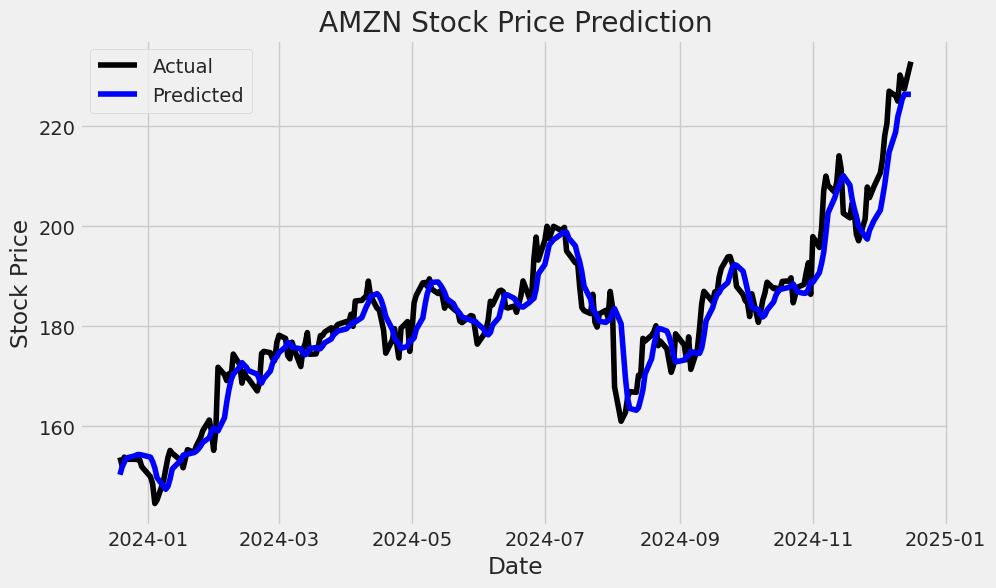

Processing predictions for AAPL...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


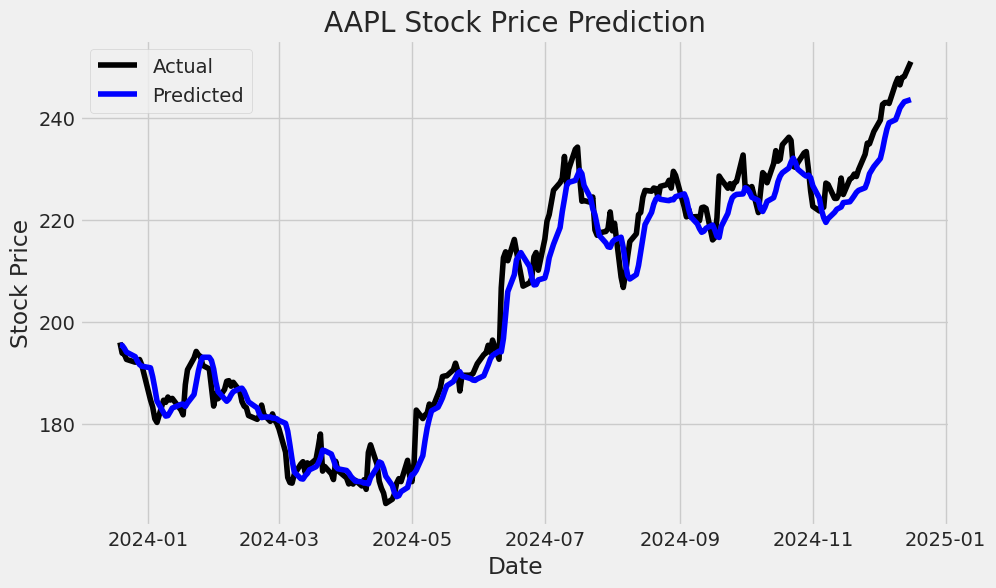

Processing predictions for META...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


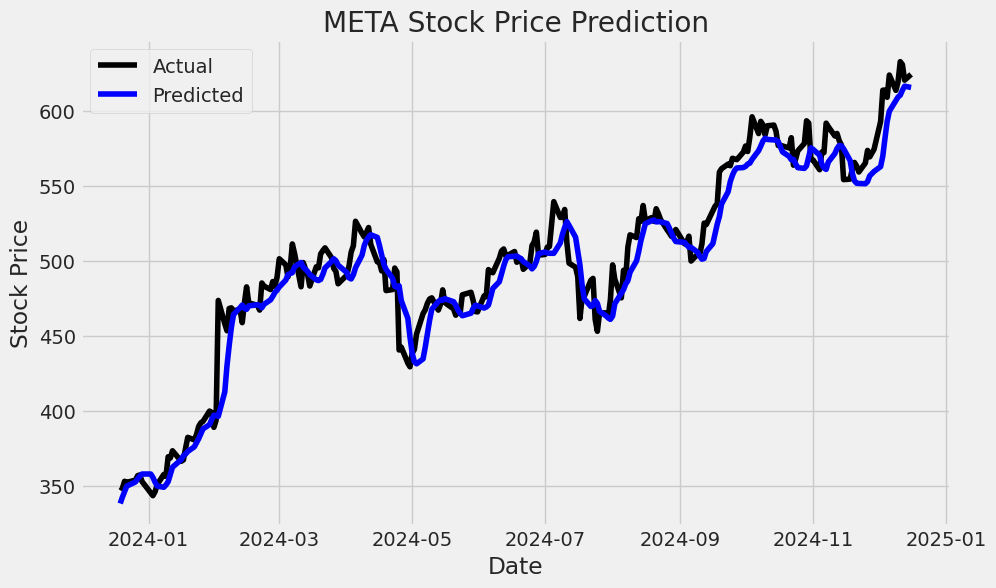

Processing predictions for NFLX...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


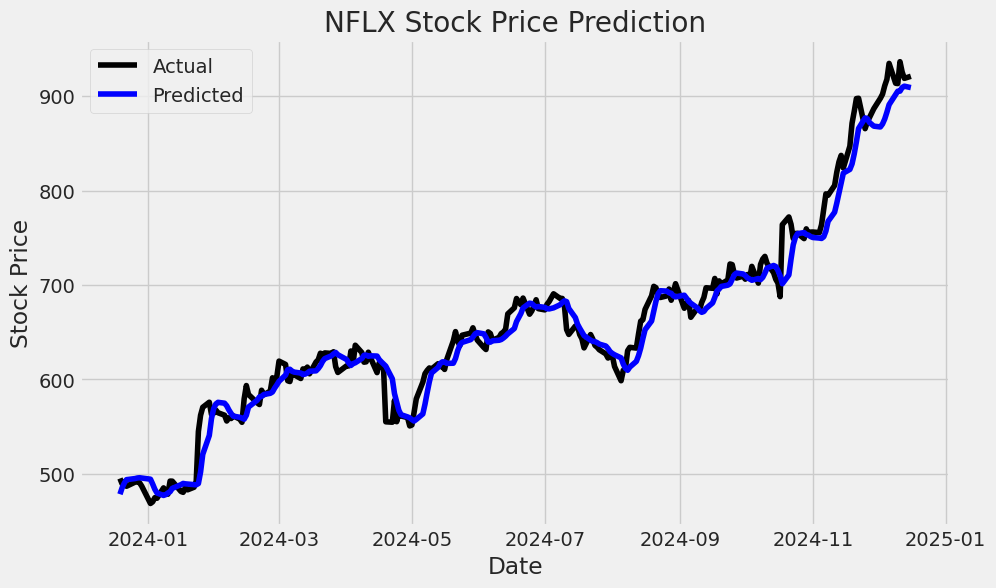

In [126]:
# List of tickers to process
tickers = ["GOOG", "AMZN", "AAPL", "META", "NFLX"]

# Loop through each ticker and plot
for ticker in tickers:
    print(f"Processing predictions for {ticker}...")
    plot_predictions_for_ticker(combined_df, ticker, model, scaler)
